<a href="https://colab.research.google.com/github/44REAM/RA-Medphys/blob/dev/Class3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Particle constant

https://docs.scipy.org/doc/scipy/reference/constants.html

In [ ]:
import scipy.constants as constants

In [ ]:
# electron mass constant (kg)
constants.m_e

9.1093837015e-31

In [ ]:
# elementary charge
constants.e

1.602176634e-19

In [ ]:
# elementary charge: charge for single proton (value, unit, uncertainty)
constants.physical_constants['elementary charge']

(1.602176634e-19, 'C', 0.0)

In [ ]:
# 1 AMU
constants.physical_constants['atomic mass unit-kilogram relationship']

(1.6605390666e-27, 'kg', 5e-37)

# Dose calculation algorithm

References

*   https://www.mdpi.com/2076-3417/11/15/6806
*   https://oncologymedicalphysics.com/dose-calculation-algorithms/



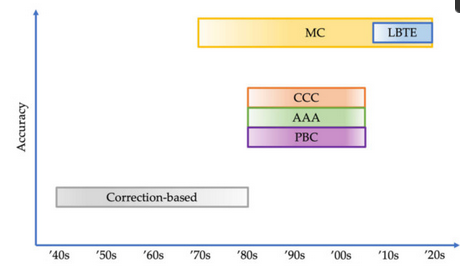

## Correction-based

## Model-based

*   Monte carlo (MC) most accurated
*   Kernel Based Algorithms
    *   Pencil Beam Convolution (PBS)
    *   Collapsed Cone Convolution (CCC)
    *   Analytical Anisotropic Algorithm (AAA)








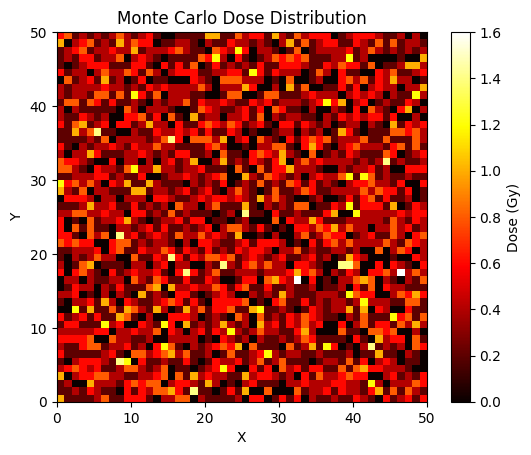

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
NUM_PARTICLES = 100000  # Number of primary particles
VOXEL_SIZE = 1.0  # Voxel size in cm
NUM_VOXELS_X = 50  # Number of voxels in x-direction
NUM_VOXELS_Y = 50  # Number of voxels in y-direction
NUM_VOXELS_Z = 20  # Number of voxels in z-direction

# Define material properties (e.g., density and mass attenuation coefficients)
material_properties = {
    "Water": {"density": 1.0, "mu": 0.2},
    "Bone": {"density": 1.5, "mu": 0.4}
}

# Generate random positions for primary particles
particle_positions = np.random.uniform(size=(NUM_PARTICLES, 3))
particle_positions *= [NUM_VOXELS_X, NUM_VOXELS_Y, NUM_VOXELS_Z]

# Define a 3D array to store the accumulated dose in each voxel
dose_array = np.zeros((NUM_VOXELS_X, NUM_VOXELS_Y, NUM_VOXELS_Z))

# Perform the simulation
for particle_idx in range(NUM_PARTICLES):
    # Get the position of the particle
    particle_pos = particle_positions[particle_idx]

    # Determine the voxel index based on the particle position
    voxel_idx = particle_pos.astype(int)

    # Determine the material of the voxel (e.g., based on CT scan data)
    voxel_material = "Water"

    # Calculate the dose deposited in the voxel based on the material properties
    dose = material_properties[voxel_material]["mu"] * VOXEL_SIZE

    # Accumulate the dose in the voxel
    dose_array[voxel_idx[0], voxel_idx[1], voxel_idx[2]] += dose

# Visualize the dose distribution in a slice of the volume
slice_idx = NUM_VOXELS_Z // 2
plt.imshow(dose_array[:, :, slice_idx].T, cmap='hot', origin='lower', extent=[0, NUM_VOXELS_X, 0, NUM_VOXELS_Y])
plt.colorbar(label="Dose (Gy)")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Monte Carlo Dose Distribution")
plt.show()

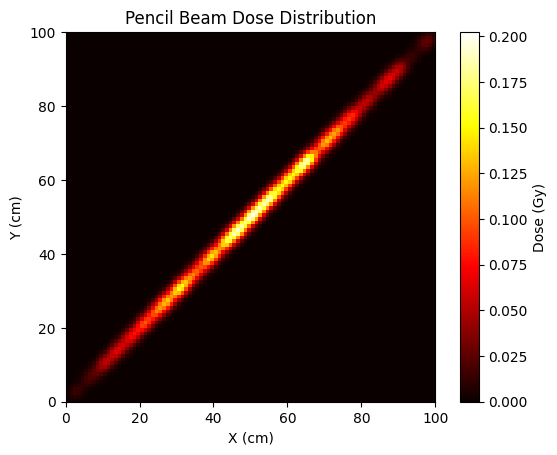

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
GRID_SIZE = 100  # Size of dose grid in cm
GRID_RESOLUTION = 0.5  # Resolution of dose grid in cm
BEAM_ENERGY = 6  # Beam energy in MeV
BEAM_WIDTH = 2.0  # Beam width in cm
SOBPS = 1000  # Number of spots in the beam

# Define material properties (e.g., mass attenuation coefficient)
material_properties = {
    "Water": {"mu": 0.2},
    "Bone": {"mu": 0.4}
}

# Generate a 2D grid for dose calculation
grid = np.zeros((GRID_SIZE, GRID_SIZE))

# Calculate the spot dose for each spot in the beam
for spot_idx in range(SOBPS):
    # Generate random spot position
    spot_x = np.random.uniform(0, GRID_SIZE)
    spot_y = np.random.uniform(0, GRID_SIZE)

    # Calculate the Gaussian dose distribution for the spot
    spot_dose = np.exp(-0.5 * ((np.arange(GRID_SIZE) - spot_x) / BEAM_WIDTH) ** 2)
    spot_dose *= np.exp(-0.5 * ((np.arange(GRID_SIZE) - spot_y) / BEAM_WIDTH) ** 2)

    # Normalize the spot dose
    spot_dose /= np.sum(spot_dose)

    # Calculate the dose contribution for the spot at each grid point
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            grid[i, j] += spot_dose[i] * spot_dose[j]

# Calculate the total dose using the material properties
grid *= material_properties["Water"]["mu"] * GRID_RESOLUTION * GRID_RESOLUTION

# Visualize the dose distribution
plt.imshow(grid.T, cmap='hot', origin='lower', extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.colorbar(label="Dose (Gy)")
plt.xlabel("X (cm)")
plt.ylabel("Y (cm)")
plt.title("Pencil Beam Dose Distribution")
plt.show()

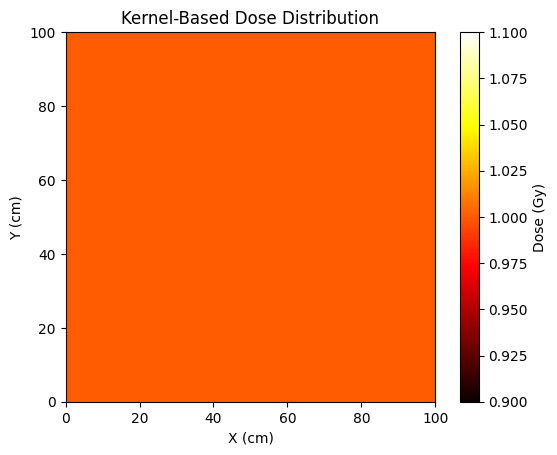

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
GRID_SIZE = 100  # Size of dose grid in cm
GRID_RESOLUTION = 0.5  # Resolution of dose grid in cm
KERNEL_SIZE = 5  # Size of dose kernel in cm
BEAM_ENERGY = 6  # Beam energy in MeV

# Define material properties (e.g., mass attenuation coefficient)
material_properties = {
    "Water": {"mu": 0.2},
    "Bone": {"mu": 0.4}
}

# Generate a 2D grid for dose calculation
grid = np.zeros((GRID_SIZE, GRID_SIZE))

# Generate a kernel based on the beam energy and kernel size
kernel = np.ones((KERNEL_SIZE, KERNEL_SIZE))

# Calculate the dose distribution by convolving the kernel with the patient's density distribution
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        # Determine the material of the voxel (e.g., based on CT scan data)
        voxel_material = "Water"

        # Convolve the kernel with the density distribution of the voxel
        dose_contribution = np.sum(kernel * material_properties[voxel_material]["mu"])

        # Calculate the dose contribution based on the mass attenuation coefficient
        dose_contribution *= material_properties[voxel_material]["mu"]

        # Accumulate the dose contribution in the grid
        grid[i, j] += dose_contribution

# Visualize the dose distribution
plt.imshow(grid.T, cmap='hot', origin='lower', extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.colorbar(label="Dose (Gy)")
plt.xlabel("X (cm)")
plt.ylabel("Y (cm)")
plt.title("Kernel-Based Dose Distribution")
plt.show()

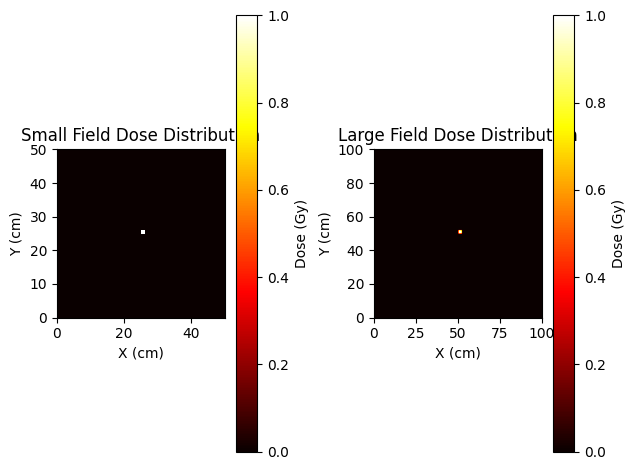

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
GRID_SIZE_SMALL = 50  # Size of dose grid for the small field in cm
GRID_SIZE_LARGE = 100  # Size of dose grid for the large field in cm
GRID_RESOLUTION = 0.5  # Resolution of dose grid in cm
SCALE_FACTOR = 2  # Scale factor for the dose distribution

# Generate a 2D grid for the small field dose distribution
small_field_grid = np.zeros((GRID_SIZE_SMALL, GRID_SIZE_SMALL))

# Generate the small field dose distribution (for demonstration purposes)
small_field_grid[GRID_SIZE_SMALL//2, GRID_SIZE_SMALL//2] = 1.0

# Perform O'Connor's scaling theorem
large_field_grid = np.zeros((GRID_SIZE_LARGE, GRID_SIZE_LARGE))
for i in range(GRID_SIZE_LARGE):
    for j in range(GRID_SIZE_LARGE):
        small_i = i // SCALE_FACTOR
        small_j = j // SCALE_FACTOR
        large_field_grid[i, j] = small_field_grid[small_i, small_j]

# Visualize the small field dose distribution
plt.subplot(1, 2, 1)
plt.imshow(small_field_grid.T, cmap='hot', origin='lower', extent=[0, GRID_SIZE_SMALL, 0, GRID_SIZE_SMALL])
plt.colorbar(label="Dose (Gy)")
plt.xlabel("X (cm)")
plt.ylabel("Y (cm)")
plt.title("Small Field Dose Distribution")

# Visualize the large field dose distribution
plt.subplot(1, 2, 2)
plt.imshow(large_field_grid.T, cmap='hot', origin='lower', extent=[0, GRID_SIZE_LARGE, 0, GRID_SIZE_LARGE])
plt.colorbar(label="Dose (Gy)")
plt.xlabel("X (cm)")
plt.ylabel("Y (cm)")
plt.title("Large Field Dose Distribution")

plt.tight_layout()
plt.show()